In [183]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.neural_network import BernoulliRBM
%matplotlib inline

# Get training data

In [184]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
train_data = mnist.train.next_batch(500)[0]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [186]:
train_data.shape

(500, 784)

# RBM based on sklearn

In [212]:
def sklearn_rbm(n_hidden, visible_data):
    """
    Binary Restricted Boltzmann Machines based on sklearn
    :param n_hidden: the number of hidden nodes
    :param visible_data: vector, visible data for visible nodes
    :return: p(h=1|v)
    """
    model = BernoulliRBM(n_components=n_hidden, random_state=1)
    model.fit(visible_data)
    return model.transform(visible_data)

def sklearn_rbm_gibbs(n_hidden, visible_data):
    """
    Binary Restricted Boltzmann Machines based on sklearn
    :param n_hidden: the number of hidden nodes
    :param visible_data: vector, visible data for visible nodes
    :return: v1, gibbs sample from v
    """
    model = BernoulliRBM(n_components=n_hidden, random_state=1)
    model.fit(visible_data)
    v_gibbs = model.gibbs(visible_data)
    return v_gibbs.astype('int32')

In [213]:
p_h_given_v_sklearn = sklearn_rbm(n_hidden=500, visible_data=train_data)
gibbs_v_sklearn = sklearn_rbm_gibbs(n_hidden=500, visible_data=train_data)

# RBM based on TensorFlow

In [138]:
def binomial_sample(prob):
    sample_out = tf.select(tf.random_uniform(shape=prob.get_shape(), minval=0, maxval=1) < prob,
                           t=tf.ones(prob.get_shape()), e=tf.zeros(prob.get_shape()))
    return sample_out

In [142]:
class RBM(object):

    def __init__(self, num_visible, num_hidden, batch_size):

        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = tf.Variable(tf.truncated_normal([num_visible, num_hidden]))
        self.v_bias = tf.Variable(tf.zeros([num_visible]))
        self.h_bias = tf.Variable(tf.zeros([num_hidden]))
        self.input_data = tf.placeholder(tf.float32, shape=[batch_size, num_visible],
                                         name='input_data')
        self.batch_size = batch_size

    def train_model(self, training_data,
                    learning_rate=0.1, k=1, max_training_step=100):
        """
        k-step contrastive divergence
        :param learning_rate:
        :return:
        """
        [p_h_given_v0, h0, p_vk_given_h, vk] = self.gibbs_sampling_v(self.input_data, k=k)
        [p_h_given_vk, hk_sample] = self.sample_h_given_v(vk)
        W_grad = (-tf.matmul(tf.transpose(self.input_data), p_h_given_v0) + \
                 tf.matmul(tf.transpose(vk), p_h_given_vk)) / self.batch_size
        v_bias_grad = tf.reduce_mean(vk - self.input_data, 0)
        h_bias_grad = tf.reduce_mean(p_h_given_vk - p_h_given_v0, 0)
        
        track_cost = []
        with tf.Session() as sess:
            init_op = tf.initialize_all_variables()
            sess.run(init_op)
            for i in range(max_training_step):
                print(i)
                W_updates = self.W - learning_rate * W_grad
                v_bias_updates = self.v_bias - learning_rate * v_bias_grad
                h_bias_updates = self.h_bias - learning_rate * h_bias_grad
                assign_op = [self.W.assign(W_updates),
                             self.v_bias.assign(v_bias_updates),
                             self.h_bias.assign(h_bias_updates)]
                sess.run(assign_op, feed_dict={self.input_data: training_data})
                this_cost = self.get_pseudo_likelihood(training_data)
                track_cost.append(this_cost)
            # save the trained parameters
            self.W = self.W.eval()
            self.v_bias = self.v_bias.eval()
            self.h_bias = self.h_bias.eval()
        return track_cost

    def p_h_given_v(self, v):
        """
        compute p(h=1|v)
        :param v:
        :return:
        """
        return tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)

    def p_v_given_h(self, h):
        """
        compute p(h=1|v)
        :param v:
        :return:
        """
        return tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)

    def sample_h_given_v(self, v0):
        p_h0_given_v0 = self.p_h_given_v(v0)
        h0_sample = binomial_sample(p_h0_given_v0)
        return [p_h0_given_v0, h0_sample]

    def sample_v_given_h(self, h0):
        p_v0_given_h0 = self.p_v_given_h(h0)
        v0_sample = binomial_sample(p_v0_given_h0)
        return [p_v0_given_h0, v0_sample]

    def gibbs_sampling_v(self, v0, k=1):
        sample_num = 0
        vk = v0
        while sample_num < k:
            [p_h_prev_given_v, h_prev] = self.sample_h_given_v(vk)
            if k == 1:
                [p_h0_given_v0, h0] = [p_h_prev_given_v, h_prev]
            [p_vk_given_h, vk] = self.sample_v_given_h(h_prev)
            sample_num += 1
        return [p_h0_given_v0, h0, p_vk_given_h, vk]

    def gibbs_sampling_h(self, h0, k=1):
        sample_num = 0
        hk = h0
        while sample_num < k:
            [p_v0_given_h, v0] = self.sample_v_given_h(hk)
            [p_hk_given_v, hk] = self.sample_h_given_v(v0)
            sample_num += 1
        return [p_hk_given_v, hk]

    def get_pseudo_likelihood(self, v0):
        v1 = self.gibbs_sampling_v(self.input_data, k=1)[3]
        v1_val = v1.eval(feed_dict={self.input_data: v0})
        return np.sum(np.abs(v1_val - v0))

In [153]:
num_visible = 28 * 28
num_hidden = 500
tf_rbm = RBM(num_visible, num_hidden, batch_size=500)

In [154]:
track_cost = tf_rbm.train_model(train_data, max_training_step=1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

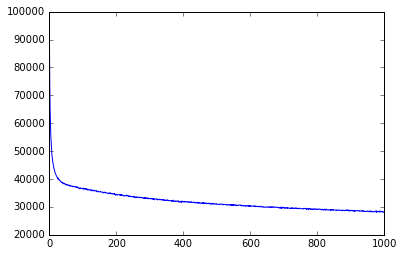

In [155]:
plt.plot(track_cost)

# Evaluate the model

In [234]:
v0 = tf.placeholder(tf.float32, shape=[500, 28 * 28])
gibbs_v_tf = tf_rbm.gibbs_sampling_v(v0)[2]
with tf.Session() as sess:
    gibbs_v_tf_val = gibbs_v_tf.eval(feed_dict={v0: train_data})

In [236]:
train_1 = np.reshape(train_data[1], (28, 28))
train_1_sklearn = np.reshape(gibbs_v_sklearn[1], (28, 28))
train_1_tf = np.reshape(gibbs_v_tf_val[1], (28, 28))

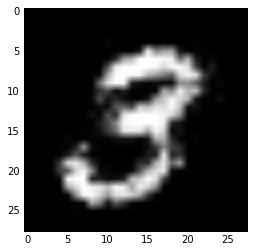

In [237]:
# Data sampled from TensotFlow RBM
plt.imshow(train_1_tf, cmap='gray')

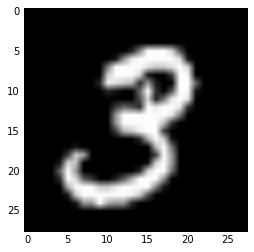

In [238]:
# Raw data
plt.imshow(train_1, cmap='gray')

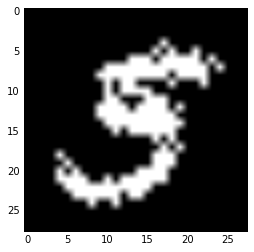

In [240]:
# Data sampled from sklearn
plt.imshow(train_1_sklearn, cmap='gray')